1. Setup & Initial Loading

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../src') 

from utils.data_loader import load_data

# Load data
df = load_data('../data/raw/complaints.csv')
# print(df.head())

d:\projects\TenAcademy\week6\KAIM-WEEK-6\notebooks\../src\utils\data_loader.py:13: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


Data loaded successfully from ../data/raw/complaints.csv


2. Initial Data Exploration

In [ ]:
# Basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9609797 entries, 0 to 9609796
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 1.3+

Handling missing data

In [3]:
# Missing values overview
print("\n=== Missing Values Summary ===")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0].sort_values(ascending=False))



=== Missing Values Summary ===
Tags                            8981029
Consumer disputed?              8841498
Consumer complaint narrative    6629041
Company public response         4770207
Consumer consent provided?      1649561
Sub-issue                        839522
Sub-product                      235295
State                             54516
ZIP code                          30228
Company response to consumer         20
Issue                                 6
dtype: int64


In [4]:
df= df.drop(columns=['Tags']).dropna(subset=['Consumer complaint narrative'])

In [5]:
# For machine learning purposes:
df['Consumer disputed?'] = df['Consumer disputed?'].fillna('Unknown')
df['Company public response'] = df['Company public response'].fillna('No response')

In [6]:
# Simple imputation for the few remaining missing values
df['Company response to consumer'] = df['Company response to consumer'].fillna('Unknown')
df['State'] = df['State'].fillna('Unknown')

In [7]:
# Check if missingness is random or systematic
missing_by_product = df[df['Sub-issue'].isna()]['Product'].value_counts(normalize=True)
print("Missing sub-issues by product:\n", missing_by_product)

Missing sub-issues by product:
 Product
Mortgage                                                                        0.358093
Money transfer, virtual currency, or money service                              0.326786
Credit card                                                                     0.063539
Payday loan, title loan, or personal loan                                       0.053496
Bank account or service                                                         0.050049
Credit reporting, credit repair services, or other personal consumer reports    0.033654
Consumer Loan                                                                   0.031812
Payday loan, title loan, personal loan, or advance loan                         0.027202
Credit reporting or other personal consumer reports                             0.019058
Debt or credit management                                                       0.009916
Prepaid card                                                          

In [8]:
# Get most common sub-issue for each main issue
mode_subissue = df.groupby('Issue')['Sub-issue'].agg(pd.Series.mode)

# Impute based on main issue
df['Sub-issue'] = df.apply(
    lambda row: mode_subissue[row['Issue']] if pd.isna(row['Sub-issue']) else row['Sub-issue'],
    axis=1
)

In [9]:
def impute_subproducts(df):
    # Create complete mapping with fallback
    mode_subproduct = (
        df[df['Sub-product'].notna()]
        .groupby('Product')['Sub-product']
        .agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else 'General')
    )
    
    # Ensure all products are represented
    product_subproduct_map = (
        mode_subproduct
        .reindex(df['Product'].unique(), fill_value='General')
        .to_dict()
    )
    
    # Apply imputation
    df['Sub-product'] = df.apply(
        lambda row: product_subproduct_map[row['Product']]
        if pd.isna(row['Sub-product'])
        else row['Sub-product'],
        axis=1
    )
    return df

# Usage
df = impute_subproducts(df)

In [10]:
print(df.isna().sum())

Date received                   0
Product                         0
Sub-product                     0
Issue                           0
Sub-issue                       0
Consumer complaint narrative    0
Company public response         0
Company                         0
State                           0
ZIP code                        0
Consumer consent provided?      0
Submitted via                   0
Date sent to company            0
Company response to consumer    0
Timely response?                0
Consumer disputed?              0
Complaint ID                    0
dtype: int64


In [11]:
# Categorical columns overview
print("\n=== Categorical Columns Overview ===")
df.describe(include='object').T


=== Categorical Columns Overview ===


,count,unique,top,freq
Date received,2980756,3736,2025-01-17,20526
Product,2980756,21,Credit reporting or other personal consumer re...,1091253
Sub-product,2980756,86,Credit reporting,1879571
Issue,2980756,173,Incorrect information on your report,901091
Sub-issue,2980756,379,Information belongs to someone else,510390
Consumer complaint narrative,2980756,2108758,In accordance with the Fair Credit Reporting a...,21622
Company public response,2980756,12,Company has responded to the consumer and the ...,1455356
Company,2980756,6542,"EQUIFAX, INC.",603410
State,2980756,64,FL,355888
ZIP code,2980756,6934,XXXXX,143211


3. Product Analysis

In [12]:
# Product distribution
print("\n=== Product Distribution ===")
product_dist = df['Product'].value_counts(normalize=True)
product_dist


=== Product Distribution ===


Product
Credit reporting or other personal consumer reports                             0.366099
Credit reporting, credit repair services, or other personal consumer reports    0.270831
Debt collection                                                                 0.112749
Checking or savings account                                                     0.047075
Mortgage                                                                        0.043667
Credit card or prepaid card                                                     0.036456
Money transfer, virtual currency, or money service                              0.032605
Credit card                                                                     0.027063
Student loan                                                                    0.017851
Vehicle loan or lease                                                           0.013278
Credit reporting                                                                0.010597
Payday loan, 

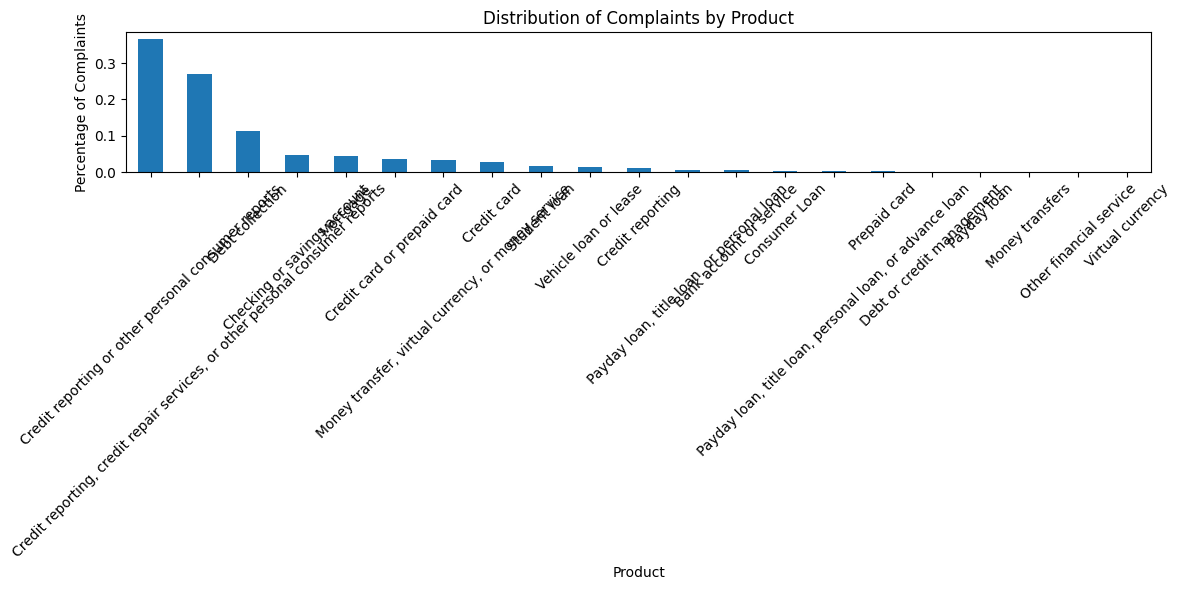

In [13]:
# Visualization
plt.figure(figsize=(12, 6))
product_dist.plot(kind='bar')
plt.title('Distribution of Complaints by Product')
plt.xlabel('Product')
plt.ylabel('Percentage of Complaints')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

4. Narrative Analysis

In [ ]:
# import tqdm
from tqdm import tqdm
tqdm.pandas()  # This enables the progress_apply method

# Add word count column with progress bar
print("\nCalculating narrative lengths...")
df['narrative_word_count'] = df['Consumer complaint narrative'].progress_apply(
    lambda x: len(str(x).split()) if pd.notnull(x) else 0
)


Calculating narrative lengths...


100%|██████████| 2980756/2980756 [01:03<00:00, 46711.05it/s] 


In [15]:
# Narrative presence
print("\n=== Narrative Presence ===")
print(f"Complaints with narratives: {(df['narrative_word_count'] > 0).sum():,}")
print(f"Complaints without narratives: {(df['narrative_word_count'] == 0).sum():,}")



=== Narrative Presence ===
Complaints with narratives: 2,980,756
Complaints without narratives: 0


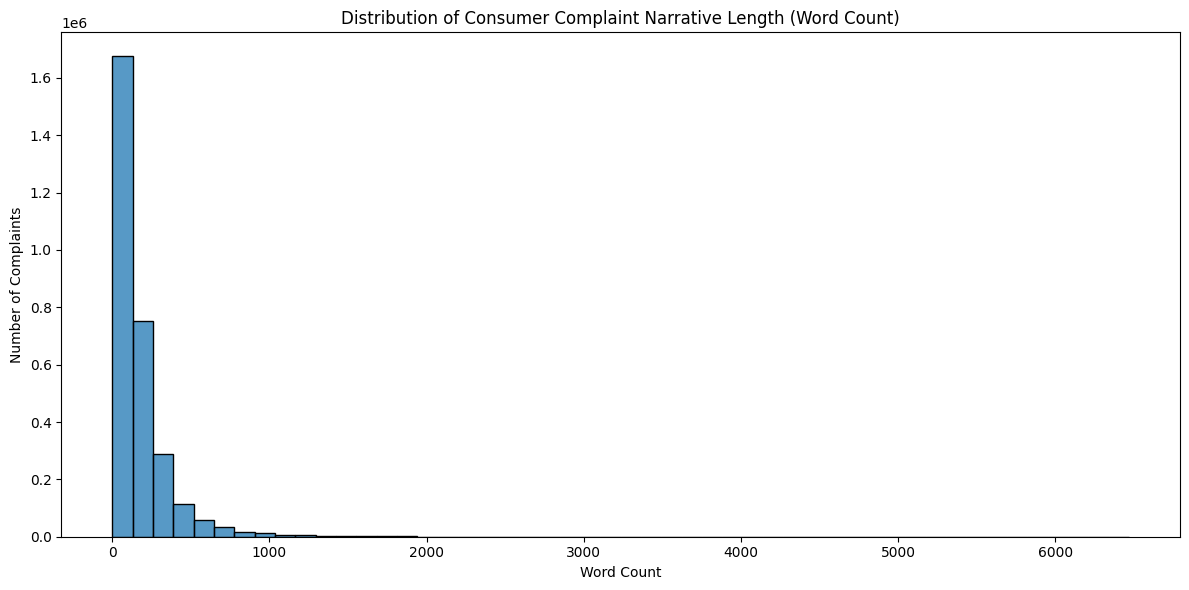

In [16]:
# Word count distribution
plt.figure(figsize=(12, 6))
sns.histplot(df[df['narrative_word_count'] > 0]['narrative_word_count'], bins=50)
plt.title('Distribution of Consumer Complaint Narrative Length (Word Count)')
plt.xlabel('Word Count')
plt.ylabel('Number of Complaints')
plt.tight_layout()
plt.show()

In [17]:
print("\n=== Narrative Length Statistics ===")
print(df[df['narrative_word_count'] > 0]['narrative_word_count'].describe())


=== Narrative Length Statistics ===
count    2.980756e+06
mean     1.755976e+02
std      2.259282e+02
min      1.000000e+00
25%      5.900000e+01
50%      1.140000e+02
75%      2.090000e+02
max      6.469000e+03
Name: narrative_word_count, dtype: float64


5. Data Filtering & Cleaning


In [18]:
import re
# Text cleaning function
def clean_text(text):
    """Clean and normalize complaint narrative text"""
    if not isinstance(text, str):
        return ""
    
    # Lowercase
    text = text.lower()
    
    # Remove boilerplate
    boilerplate = [
        r'i am writing to file a complaint',
        r'this is a complaint',
        r'dear consumer financial protection bureau',
        r'to whom it may concern'
    ]
    for phrase in boilerplate:
        text = re.sub(phrase, '', text)
    
    # Remove special chars and extra whitespace
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [19]:
# Filter for target products
target_products = [
    'Credit card', 
    'Personal loan', 
    'Buy Now, Pay Later (BNPL)', 
    'Savings account', 
    'Money transfers'
]

print("\n=== Filtering Data ===")
filtered_df = df[df['Product'].isin(target_products)].copy()
print(f"After product filtering: {filtered_df.shape[0]:,} records")


=== Filtering Data ===
After product filtering: 82,164 records


In [20]:
# Remove empty narratives
filtered_df = filtered_df[filtered_df['Consumer complaint narrative'].notna()]
filtered_df = filtered_df[filtered_df['Consumer complaint narrative'].str.strip() != '']
print(f"After removing empty narratives: {filtered_df.shape[0]:,} records")

After removing empty narratives: 82,164 records


In [21]:
# Clean narratives
import re
print("\nCleaning narratives...")
filtered_df['cleaned_narrative'] = filtered_df['Consumer complaint narrative'].progress_apply(clean_text)


Cleaning narratives...


100%|██████████| 82164/82164 [00:17<00:00, 4713.65it/s]


In [22]:
# Remove empty after cleaning
filtered_df = filtered_df[filtered_df['cleaned_narrative'].str.strip() != '']
print(f"After cleaning: {filtered_df.shape[0]:,} records")

After cleaning: 82,164 records


6. Save Processed Data

In [23]:
# Save to CSV
print("\nSaving filtered data...")
filtered_df.to_csv("../data/processed/filtered_complaints.csv", index=False)
print(f"Saved to {"../data/processed/filtered_complaints.csv"}")



Saving filtered data...
Saved to ../data/processed/filtered_complaints.csv


In [24]:
# %%
# Final summary
print("\n=== Processing Complete ===")
print(f"Original dataset size: {df.shape[0]:,} records")
print(f"Filtered dataset size: {filtered_df.shape[0]:,} records")
print(f"Products included: {target_products}")


=== Processing Complete ===
Original dataset size: 2,980,756 records
Filtered dataset size: 82,164 records
Products included: ['Credit card', 'Personal loan', 'Buy Now, Pay Later (BNPL)', 'Savings account', 'Money transfers']
